In [110]:
import numpy as np
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import mixture

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import sys
sys.path.append('../modules_for_nn_training')
from callbacks import CallbackHandler
from learner import Learner
from trainer import Trainer
from utility_callbacks import LossCallback

## Data

In [220]:
ys = np.linspace(0, 1, 5000)

In [221]:
def get_xs(ys):
    xs = 0.5 * (((2 * ys - 1.3) ** 3 + (2 * ys - 1.3) ** 2) * 6 + 0.6)
    noises = np.random.normal(loc=0, scale=0.2, size=len(ys))
    return xs + noises

In [222]:
xs = get_xs(ys)

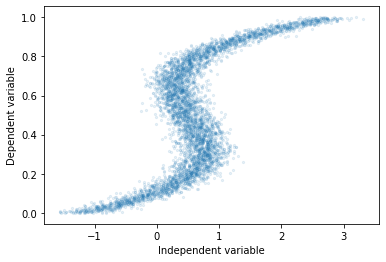

In [223]:
plt.scatter(xs, ys, s=5, alpha=0.1)
plt.xlabel('Independent variable'); plt.ylabel('Dependent variable')
plt.show()

In [75]:
xs, ys = xs.reshape(-1, 1), ys.reshape(-1, 1)

In [76]:
def train_test_split(xs, ys, train_prop):
    train_num = int(train_prop * len(xs))
    idxs = np.arange(len(xs))
    np.random.shuffle(idxs)
    train_idxs, valid_idxs = idxs[:train_num], idxs[train_num:]
    return (xs[train_idxs], ys[train_idxs]), (xs[valid_idxs], ys[valid_idxs])

In [45]:
(x_train, y_train), (x_valid, y_valid) = train_test_split(xs, ys, 0.8)

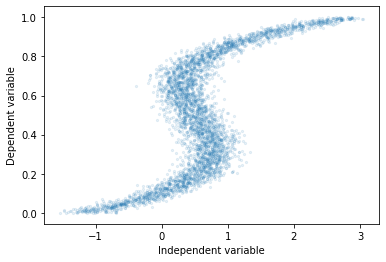

In [77]:
plt.scatter(x_train, y_train, s=5, alpha=0.1)
plt.xlabel('Independent variable'); plt.ylabel('Dependent variable')
plt.show()

In [225]:
num_components = 3
g = mixture.GaussianMixture(n_components=num_components, covariance_type='diag')
xy_train = np.hstack([x_train, y_train])
g = g.fit(xy_train)

In [226]:
X, Y = np.s_[:,0], np.s_[:,1]

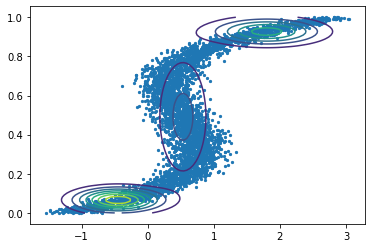

In [227]:
plt.scatter(xy_train[X], xy_train[Y], s=5)

xs,  ys  = np.linspace(np.min(xy_train[X]), np.max(xy_train[X]), 100), np.linspace(np.min(xy_train[Y]), np.max(xy_train[Y]), 100)
xxs, yys = np.meshgrid(xs, ys)

probas_sum = np.zeros((100, 100))

for mean, cov in zip(g.means_, g.covariances_):
    norm_dist = multivariate_normal(mean=mean, cov=cov)
    probas_sum += norm_dist.pdf(np.hstack([xxs.reshape(-1, 1), yys.reshape(-1, 1)])).reshape(100, 100)

probas_mean = probas_sum / num_components
plt.contour(xxs, yys, probas_mean)

plt.show()

In [214]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((4000, 1), (4000, 1), (1000, 1), (1000, 1))

In [215]:
train_ds = TensorDataset(torch.from_numpy(x_train).cpu(), torch.from_numpy(y_train).cpu())
valid_ds = TensorDataset(torch.from_numpy(x_valid).cpu(), torch.from_numpy(y_valid).cpu())
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False)

## Model

In [177]:
class CDEstimator(nn.Module):
    
    """Conditional density estimator using neural networks."""
    
    def __init__(self, input_dim, output_dim, num_comps, num_hidden=1):
        
        super().__init__()
        
        self.num_comps = num_comps
        self.output_dim = output_dim
        
        self.get_mixing_coeffs = nn.Sequential(
            
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps),
            nn.Softmax(dim=1)
        
        )
        
        self.get_means = nn.Sequential(
        
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps * output_dim),
            
        )
        
        self.get_logvars = nn.Sequential(
        
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps),
        
        )
        
    def forward(self, x):
        
        mixing_coeffs = self.get_mixing_coeffs(x)
        means = self.get_means(x).view((-1, self.num_comps, self.output_dim))
        variances = torch.exp(self.get_logvars(x)) 
        
        return {
            'mixing_coeffs' : mixing_coeffs,
            'means' : means,
            'variances' : variances
        }

In [179]:
def get_densities_under_gmm(mixing_coeffs, means, variances, t):
    
    probas = torch.zeros(t.size(0)).cpu()
    
    num_components = mixing_coeffs.size(1)
    output_dim = t.size(1)
    
    for j in range(num_components):
        probas += mixing_coeffs[:,j] * (
            1 / 
            (
                (2 * np.pi) ** (output_dim / 2) * (variances[:, j] ** 0.5) ** output_dim
            )
        ) * torch.exp(- torch.norm(t - means[:, j], dim=1) / (2 * variances[:, j]))
    
    return probas

In [180]:
def nll_loss(params, t):
    probas = get_densities_under_gmm(params['mixing_coeffs'], params['means'], params['variances'], t)
    return - torch.sum(torch.log(probas))

In [247]:
def get_model():
    nn = CDEstimator(1, 1, 10, 5)
    return nn, optim.Adam(nn.parameters(), lr=0.01)

In [248]:
model, opt = get_model()
learn = Learner(train_dl, valid_dl, model.cpu(), nll_loss, opt)

loss_cb = LossCallback()
cb_handler = CallbackHandler(cbs=[loss_cb])

trainer = Trainer(learn=learn, cb_handler=cb_handler)

In [249]:
# make sure to reset this step; it gives a poor start to training because it ends up with high loss
# trainer.find_lr(beta=0.98, final_value=10, num_itr=300)

In [250]:
trainer.set_lr(0.05)
trainer.train(num_epoch=100)

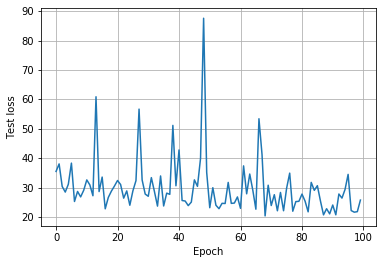

In [252]:
loss_cb.plot()
plt.show()

In [253]:
model.cpu()
mixing_coeffs_valid = model(torch.from_numpy(x_train).float())['mixing_coeffs']

In [254]:
mixing_coeffs_valid.shape

torch.Size([4000, 10])

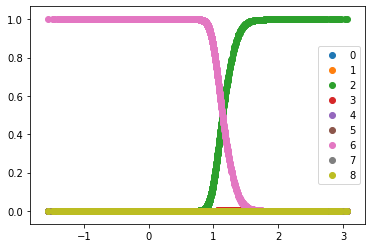

In [256]:
for i in range(9):
    plt.scatter(x_train.flatten(), mixing_coeffs_valid[:,i].detach().numpy(), label=i)
plt.legend()
plt.show()